(-0.5, 1919.5, 1079.5, -0.5)

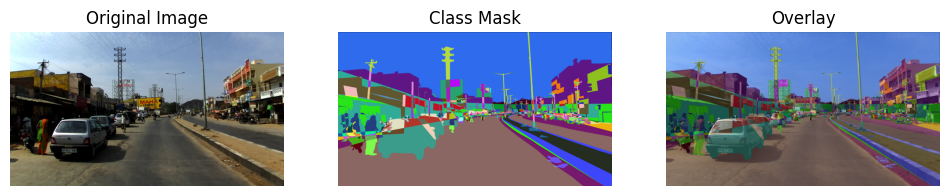

In [1]:
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random

# Load JSON file
with open("E:\\Projects\\Finished\\Semantic Segmentation\\idd20kII\\gtFine\\train\\201\\frame0029_gtFine_polygons.json", 'r') as f:
    data = json.load(f)

# Extract image dimensions
img_height = data["imgHeight"]
img_width = data["imgWidth"]

# Initialize an empty RGB mask
mask = np.zeros((img_height, img_width, 3), dtype=np.uint8)

# Assign random colors to each unique label
unique_labels = {obj["label"] for obj in data["objects"] if not obj["deleted"]}
label_colors = {label: tuple(random.choices(range(256), k=3)) for label in unique_labels}

# Generate masks for all labels
for obj in data["objects"]:
    if not obj["deleted"]:
        label = obj["label"]
        polygon = obj["polygon"]
        color = label_colors[label]  # Get color for the label
        
        # Convert polygon points to a tuple of tuples
        polygon = [(point[0], point[1]) for point in polygon]
        
        # Draw the polygon on the mask
        img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
        ImageDraw.Draw(img).polygon(polygon, outline=color, fill=color)
        mask += np.array(img, dtype=np.uint8)

# Load a sample image (Replace 'sample_image.jpg' with the path to your image)
image_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\train\201\frame0029_leftImg8bit.jpg'  # Replace with your image file path
image = Image.open(image_path).convert("RGB")

# Overlay the mask on the image
mask_overlay = Image.fromarray(mask)
overlay = Image.blend(image, mask_overlay, alpha=0.5)

# Display the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Class Mask")
plt.imshow(mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

250it [00:10, 24.54it/s]


Found 7034 images
Found 7034 masks
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])


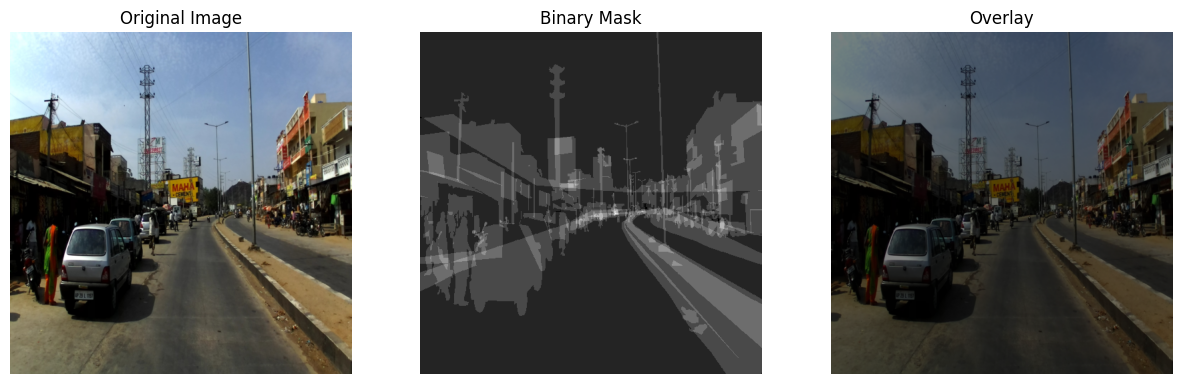

In [6]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
from tqdm import tqdm

import json
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

class IDD20KLLDataset(Dataset):
    def __init__(self, image_root, mask_root, feature_extractor, transforms=None):
        self.image_paths = []
        self.mask_paths = []
        self.feature_extractor = feature_extractor
        self.transforms = transforms

        # Collect all image and mask paths
        for subdir, _, files in tqdm(os.walk(mask_root)):  # Iterate through mask_root
            for file in files:
                if file.endswith("_gtFine_polygons.json"):  # JSON files
                    # Extract the base filename (e.g., "frame0029")
                    base_name = file.replace("_gtFine_polygons.json", "")
                    # Construct paths
                    mask_path = Path(subdir) / file
                    image_path = Path(image_root) / Path(subdir).relative_to(mask_root) / f"{base_name}_leftImg8bit.jpg"

                    # Check if corresponding image exists
                    if image_path.exists():
                        self.mask_paths.append(mask_path)
                        self.image_paths.append(image_path)
                    else:
                        print(f"Warning: Image not found for mask: {mask_path}")

        print(f"Found {len(self.image_paths)} images")
        print(f"Found {len(self.mask_paths)} masks")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask_path = self.mask_paths[idx]

        # Generate class mask from JSON
        mask = self.create_class_mask(mask_path, image.size)  # Returns a PIL Image

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)  # Transform image
            # Ensure mask is resized and remains as a PIL Image for resizing
            mask = transforms.Resize((512, 512))(mask)
            mask = np.array(mask)  # Convert mask to NumPy array
            mask = torch.tensor(mask, dtype=torch.long)  # Convert to tensor after all transformations

        # Prepare inputs for the model
        return {
            "pixel_values": image,  # Preprocessed image
            "labels": mask,  # Single-channel integer mask
        }

    @staticmethod
    def create_class_mask(json_path, image_size):
        with open(json_path, 'r') as f:
            data = json.load(f)

        img_width, img_height = image_size
        mask = np.zeros((img_height, img_width), dtype=np.uint8)  # Single-channel binary mask

        # Draw polygons for all labels
        for obj in data["objects"]:
            if not obj["deleted"]:
                polygon = [(point[0], point[1]) for point in obj["polygon"]]
                # Skip polygons with fewer than 2 points
                if len(polygon) < 2:
                    print(f"Warning: Skipping invalid polygon with {len(polygon)} points in {json_path}")
                    continue
                img = Image.new("L", (img_width, img_height), 0)  # "L" mode creates a single-channel grayscale image
                ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
                mask += np.array(img, dtype=np.uint8)

        return Image.fromarray(mask)  # Return as a PIL Image



# Paths
mask_root = "E:\\Projects\\Finished\\Semantic Segmentation\\idd20kII\\gtFine"
image_root = "E:\\Projects\\Finished\\Semantic Segmentation\\idd20kII\\leftImg8bit"
train_image_root = os.path.join(image_root, "train")
train_mask_root = os.path.join(mask_root, "train")

# Load Feature Extractor
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images and masks
    transforms.ToTensor(),
])

# Create Dataset Instance
train_dataset = IDD20KLLDataset(train_image_root, train_mask_root, feature_extractor, transforms=transform)

def verify_sample(dataset, idx=0):
    sample = dataset[idx]
    image = sample["pixel_values"]
    mask = sample["labels"]

    print("Image shape:", image.shape)  # Should be (3, 512, 512)
    print("Mask shape:", mask.shape)  # Should be (512, 512)

    # Convert tensors back to PIL images for visualization
    image = transforms.ToPILImage()(image)
    mask = transforms.ToPILImage()(mask.byte().unsqueeze(0))  # Convert to uint8 and add channel

    # Overlay the mask on the image
    mask_rgb = mask.convert("RGB")  # Convert grayscale mask to RGB for overlay
    overlay = Image.blend(image, mask_rgb, alpha=0.5)

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Binary Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


# Verify a sample before training
verify_sample(train_dataset, idx=0)


In [3]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, Trainer, TrainingArguments
import torch
import os
from torch.utils.data import Subset

# Define paths
val_image_root = os.path.join(image_root, "val")
val_mask_root = os.path.join(mask_root, "val")

# Prepare datasets
train_dataset_full = IDD20KLLDataset(train_image_root, train_mask_root, feature_extractor, transforms=transform)
val_dataset = IDD20KLLDataset(val_image_root, val_mask_root, feature_extractor, transforms=transform)

# Limit the training dataset to 1000 samples
train_dataset = Subset(train_dataset_full, range(1000))

# Load the Segformer model
num_labels = 34  # Adjust this based on the number of unique labels in your dataset
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=num_labels,  # Number of classes
    ignore_mismatched_sizes=True,  # Allows resizing the final layer for custom datasets
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./segformer-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # Adjust based on available GPU memory
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    remove_unused_columns=False,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=torch.cuda.is_available(),  # Use mixed precision if supported
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("segformer-finetuned")


250it [00:01, 214.35it/s]


Found 7034 images
Found 7034 masks


51it [00:04, 12.31it/s]


Found 1055 images
Found 1055 masks


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([34]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([34, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 3.5763, 'grad_norm': 5.092167377471924, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.04}
{'loss': 3.364, 'grad_norm': 5.228883743286133, 'learning_rate': 4.96e-05, 'epoch': 0.08}
{'loss': 3.1811, 'grad_norm': 4.869215965270996, 'learning_rate': 4.94e-05, 'epoch': 0.12}
{'loss': 3.0176, 'grad_norm': 5.24432373046875, 'learning_rate': 4.92e-05, 'epoch': 0.16}
{'loss': 2.8474, 'grad_norm': 5.422859191894531, 'learning_rate': 4.9e-05, 'epoch': 0.2}
{'loss': 2.6705, 'grad_norm': 5.228950023651123, 'learning_rate': 4.88e-05, 'epoch': 0.24}
{'loss': 2.6384, 'grad_norm': 5.632293701171875, 'learning_rate': 4.86e-05, 'epoch': 0.28}
{'loss': 2.4857, 'grad_norm': 4.7369794845581055, 'learning_rate': 4.8400000000000004e-05, 'epoch': 0.32}
{'loss': 2.3393, 'grad_norm': 4.805081367492676, 'learning_rate': 4.82e-05, 'epoch': 0.36}
{'loss': 2.2156, 'grad_norm': 4.49395227432251, 'learning_rate': 4.8e-05, 'epoch': 0.4}
{'loss': 2.1419, 'grad_norm': 4.102570056915283, 'learning_rate': 4.

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 526.3178, 'eval_samples_per_second': 2.004, 'eval_steps_per_second': 0.502, 'epoch': 1.0}
{'loss': 1.2993, 'grad_norm': 4.595865726470947, 'learning_rate': 4.4800000000000005e-05, 'epoch': 1.04}
{'loss': 1.2184, 'grad_norm': 5.026262283325195, 'learning_rate': 4.46e-05, 'epoch': 1.08}
{'loss': 1.2282, 'grad_norm': 2.541667938232422, 'learning_rate': 4.44e-05, 'epoch': 1.12}
{'loss': 1.1833, 'grad_norm': 3.216752290725708, 'learning_rate': 4.4200000000000004e-05, 'epoch': 1.16}
{'loss': 1.1406, 'grad_norm': 2.279338836669922, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.2}
{'loss': 1.0754, 'grad_norm': 2.596991539001465, 'learning_rate': 4.38e-05, 'epoch': 1.24}
{'loss': 1.0328, 'grad_norm': 2.9222571849823, 'learning_rate': 4.36e-05, 'epoch': 1.28}
{'loss': 1.0798, 'grad_norm': 2.9753828048706055, 'learning_rate': 4.3400000000000005e-05, 'epoch': 1.32}
{'loss': 1.0317, 'grad_norm': 3.120143175125122, 'learning_rate': 4.32e-05, 'epoch': 1.36}
{'

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 490.2942, 'eval_samples_per_second': 2.152, 'eval_steps_per_second': 0.538, 'epoch': 2.0}
{'loss': 0.7393, 'grad_norm': 1.6114835739135742, 'learning_rate': 3.9800000000000005e-05, 'epoch': 2.04}
{'loss': 0.7567, 'grad_norm': 1.5018821954727173, 'learning_rate': 3.960000000000001e-05, 'epoch': 2.08}
{'loss': 0.7147, 'grad_norm': 1.726158857345581, 'learning_rate': 3.94e-05, 'epoch': 2.12}
{'loss': 0.7149, 'grad_norm': 0.9442792534828186, 'learning_rate': 3.9200000000000004e-05, 'epoch': 2.16}
{'loss': 0.7033, 'grad_norm': 1.4155217409133911, 'learning_rate': 3.9000000000000006e-05, 'epoch': 2.2}
{'loss': 0.6967, 'grad_norm': 1.5618648529052734, 'learning_rate': 3.88e-05, 'epoch': 2.24}
{'loss': 0.7057, 'grad_norm': 3.9455618858337402, 'learning_rate': 3.86e-05, 'epoch': 2.28}
{'loss': 0.6976, 'grad_norm': 1.3148404359817505, 'learning_rate': 3.8400000000000005e-05, 'epoch': 2.32}
{'loss': 0.6863, 'grad_norm': 1.7631330490112305, 'learning_rate': 3.82e

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 496.307, 'eval_samples_per_second': 2.126, 'eval_steps_per_second': 0.532, 'epoch': 3.0}
{'loss': 0.6187, 'grad_norm': 1.2733590602874756, 'learning_rate': 3.48e-05, 'epoch': 3.04}
{'loss': 0.6401, 'grad_norm': 2.0215280055999756, 'learning_rate': 3.46e-05, 'epoch': 3.08}
{'loss': 0.6318, 'grad_norm': 1.646161675453186, 'learning_rate': 3.4399999999999996e-05, 'epoch': 3.12}
{'loss': 0.6158, 'grad_norm': 2.414684534072876, 'learning_rate': 3.4200000000000005e-05, 'epoch': 3.16}
{'loss': 0.6093, 'grad_norm': 1.7235784530639648, 'learning_rate': 3.4000000000000007e-05, 'epoch': 3.2}
{'loss': 0.584, 'grad_norm': 2.371091842651367, 'learning_rate': 3.38e-05, 'epoch': 3.24}
{'loss': 0.6629, 'grad_norm': 3.5354788303375244, 'learning_rate': 3.3600000000000004e-05, 'epoch': 3.28}
{'loss': 0.6048, 'grad_norm': 1.9008057117462158, 'learning_rate': 3.3400000000000005e-05, 'epoch': 3.32}
{'loss': 0.5828, 'grad_norm': 1.632330298423767, 'learning_rate': 3.32e-05,

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 496.4993, 'eval_samples_per_second': 2.125, 'eval_steps_per_second': 0.532, 'epoch': 4.0}
{'loss': 0.578, 'grad_norm': 1.0573891401290894, 'learning_rate': 2.98e-05, 'epoch': 4.04}
{'loss': 0.5929, 'grad_norm': 2.120399236679077, 'learning_rate': 2.96e-05, 'epoch': 4.08}
{'loss': 0.567, 'grad_norm': 1.4516524076461792, 'learning_rate': 2.94e-05, 'epoch': 4.12}
{'loss': 0.6213, 'grad_norm': 1.9848273992538452, 'learning_rate': 2.9199999999999998e-05, 'epoch': 4.16}
{'loss': 0.6145, 'grad_norm': 2.39884352684021, 'learning_rate': 2.9e-05, 'epoch': 4.2}
{'loss': 0.5629, 'grad_norm': 1.6131925582885742, 'learning_rate': 2.88e-05, 'epoch': 4.24}
{'loss': 0.574, 'grad_norm': 0.8967933058738708, 'learning_rate': 2.86e-05, 'epoch': 4.28}
{'loss': 0.5915, 'grad_norm': 0.9750183820724487, 'learning_rate': 2.84e-05, 'epoch': 4.32}
{'loss': 0.5344, 'grad_norm': 1.3246806859970093, 'learning_rate': 2.8199999999999998e-05, 'epoch': 4.36}
{'loss': 0.5491, 'grad_norm

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 495.5196, 'eval_samples_per_second': 2.129, 'eval_steps_per_second': 0.533, 'epoch': 5.0}
{'loss': 0.5713, 'grad_norm': 2.048679828643799, 'learning_rate': 2.48e-05, 'epoch': 5.04}
{'loss': 0.5649, 'grad_norm': 1.1277320384979248, 'learning_rate': 2.46e-05, 'epoch': 5.08}
{'loss': 0.5758, 'grad_norm': 3.717146635055542, 'learning_rate': 2.442e-05, 'epoch': 5.12}
{'loss': 0.5369, 'grad_norm': 1.1960700750350952, 'learning_rate': 2.4220000000000002e-05, 'epoch': 5.16}
{'loss': 0.5325, 'grad_norm': 1.8941689729690552, 'learning_rate': 2.402e-05, 'epoch': 5.2}
{'loss': 0.53, 'grad_norm': 2.5099878311157227, 'learning_rate': 2.3820000000000002e-05, 'epoch': 5.24}
{'loss': 0.5653, 'grad_norm': 1.335951328277588, 'learning_rate': 2.362e-05, 'epoch': 5.28}
{'loss': 0.5167, 'grad_norm': 1.4350221157073975, 'learning_rate': 2.342e-05, 'epoch': 5.32}
{'loss': 0.6062, 'grad_norm': 2.4280447959899902, 'learning_rate': 2.322e-05, 'epoch': 5.36}
{'loss': 0.541, 'gra

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 486.2906, 'eval_samples_per_second': 2.169, 'eval_steps_per_second': 0.543, 'epoch': 6.0}
{'loss': 0.5766, 'grad_norm': 1.3360627889633179, 'learning_rate': 1.982e-05, 'epoch': 6.04}
{'loss': 0.5156, 'grad_norm': 1.2892462015151978, 'learning_rate': 1.9620000000000002e-05, 'epoch': 6.08}
{'loss': 0.5068, 'grad_norm': 2.4718515872955322, 'learning_rate': 1.942e-05, 'epoch': 6.12}
{'loss': 0.5574, 'grad_norm': 2.5013177394866943, 'learning_rate': 1.9220000000000002e-05, 'epoch': 6.16}
{'loss': 0.5826, 'grad_norm': 1.6518017053604126, 'learning_rate': 1.902e-05, 'epoch': 6.2}
{'loss': 0.502, 'grad_norm': 2.39076828956604, 'learning_rate': 1.8820000000000003e-05, 'epoch': 6.24}
{'loss': 0.5609, 'grad_norm': 2.8022336959838867, 'learning_rate': 1.862e-05, 'epoch': 6.28}
{'loss': 0.5276, 'grad_norm': 1.8218053579330444, 'learning_rate': 1.842e-05, 'epoch': 6.32}
{'loss': 0.541, 'grad_norm': 1.7394154071807861, 'learning_rate': 1.8220000000000002e-05, 'epoch

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 484.6131, 'eval_samples_per_second': 2.177, 'eval_steps_per_second': 0.545, 'epoch': 7.0}
{'loss': 0.5477, 'grad_norm': 3.853203773498535, 'learning_rate': 1.482e-05, 'epoch': 7.04}
{'loss': 0.5692, 'grad_norm': 2.8441436290740967, 'learning_rate': 1.462e-05, 'epoch': 7.08}
{'loss': 0.5254, 'grad_norm': 2.356008529663086, 'learning_rate': 1.4420000000000001e-05, 'epoch': 7.12}
{'loss': 0.4969, 'grad_norm': 2.184917688369751, 'learning_rate': 1.422e-05, 'epoch': 7.16}
{'loss': 0.5338, 'grad_norm': 5.931649208068848, 'learning_rate': 1.402e-05, 'epoch': 7.2}
{'loss': 0.5811, 'grad_norm': 1.1853646039962769, 'learning_rate': 1.382e-05, 'epoch': 7.24}
{'loss': 0.4794, 'grad_norm': 1.7797471284866333, 'learning_rate': 1.362e-05, 'epoch': 7.28}
{'loss': 0.5347, 'grad_norm': 1.8446308374404907, 'learning_rate': 1.3420000000000002e-05, 'epoch': 7.32}
{'loss': 0.5336, 'grad_norm': 1.249861240386963, 'learning_rate': 1.3220000000000002e-05, 'epoch': 7.36}
{'los

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 494.3932, 'eval_samples_per_second': 2.134, 'eval_steps_per_second': 0.534, 'epoch': 8.0}
{'loss': 0.5187, 'grad_norm': 6.488912105560303, 'learning_rate': 9.820000000000001e-06, 'epoch': 8.04}
{'loss': 0.5335, 'grad_norm': 2.3596956729888916, 'learning_rate': 9.62e-06, 'epoch': 8.08}
{'loss': 0.5129, 'grad_norm': 1.3745447397232056, 'learning_rate': 9.420000000000001e-06, 'epoch': 8.12}
{'loss': 0.5182, 'grad_norm': 1.5994919538497925, 'learning_rate': 9.220000000000002e-06, 'epoch': 8.16}
{'loss': 0.5127, 'grad_norm': 1.9444172382354736, 'learning_rate': 9.02e-06, 'epoch': 8.2}
{'loss': 0.5483, 'grad_norm': 1.9021531343460083, 'learning_rate': 8.82e-06, 'epoch': 8.24}
{'loss': 0.5284, 'grad_norm': 2.51033091545105, 'learning_rate': 8.62e-06, 'epoch': 8.28}
{'loss': 0.5316, 'grad_norm': 2.4672038555145264, 'learning_rate': 8.42e-06, 'epoch': 8.32}
{'loss': 0.5153, 'grad_norm': 2.5974414348602295, 'learning_rate': 8.22e-06, 'epoch': 8.36}
{'loss': 0.5

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 491.9793, 'eval_samples_per_second': 2.144, 'eval_steps_per_second': 0.537, 'epoch': 9.0}
{'loss': 0.531, 'grad_norm': 1.8043001890182495, 'learning_rate': 4.8200000000000004e-06, 'epoch': 9.04}
{'loss': 0.5754, 'grad_norm': 1.979778528213501, 'learning_rate': 4.62e-06, 'epoch': 9.08}
{'loss': 0.4999, 'grad_norm': 1.385398268699646, 'learning_rate': 4.420000000000001e-06, 'epoch': 9.12}
{'loss': 0.4969, 'grad_norm': 1.8834562301635742, 'learning_rate': 4.22e-06, 'epoch': 9.16}
{'loss': 0.5218, 'grad_norm': 0.9709563255310059, 'learning_rate': 4.0200000000000005e-06, 'epoch': 9.2}
{'loss': 0.5147, 'grad_norm': 2.204939365386963, 'learning_rate': 3.82e-06, 'epoch': 9.24}
{'loss': 0.5012, 'grad_norm': 1.1463876962661743, 'learning_rate': 3.6200000000000005e-06, 'epoch': 9.28}
{'loss': 0.5113, 'grad_norm': 2.3825902938842773, 'learning_rate': 3.4200000000000003e-06, 'epoch': 9.32}
{'loss': 0.5277, 'grad_norm': 1.807904601097107, 'learning_rate': 3.22e-06,

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': nan, 'eval_runtime': 490.0742, 'eval_samples_per_second': 2.153, 'eval_steps_per_second': 0.539, 'epoch': 10.0}
{'train_runtime': 11358.3494, 'train_samples_per_second': 0.88, 'train_steps_per_second': 0.22, 'train_loss': 0.7595249477386474, 'epoch': 10.0}


c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


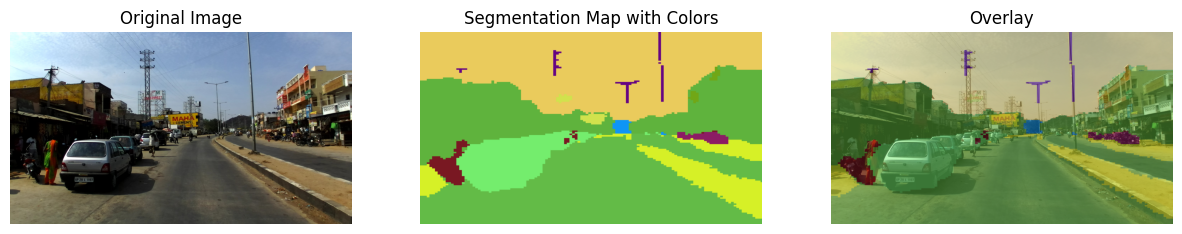

In [4]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

# Load the pre-trained base Segformer model and feature extractor
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Define the test image path
test_image_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\train\201\frame0029_leftImg8bit.jpg'
test_image = Image.open(test_image_path).convert("RGB")

inputs = feature_extractor(images=test_image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  
segmentation_map = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy() 

# Resize the segmentation map to match the original image
height, width = test_image.size[::-1]  
segmentation_map_resized = zoom(segmentation_map, (height / segmentation_map.shape[0], width / segmentation_map.shape[1]), order=0)

# Define a color map for classes (random colors for each class)
num_classes = logits.shape[1]
color_map = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)

# Map the segmentation map to RGB colors
segmentation_map_rgb = np.zeros((height, width, 3), dtype=np.uint8)
for class_idx in range(num_classes):
    segmentation_map_rgb[segmentation_map_resized == class_idx] = color_map[class_idx]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(segmentation_map_rgb)
plt.title("Segmentation Map with Colors")
plt.axis("off")

overlay = (0.5 * np.array(test_image) + 0.5 * segmentation_map_rgb).astype(np.uint8)
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


72it [00:00, 1131.04it/s]


Found 2009 images.


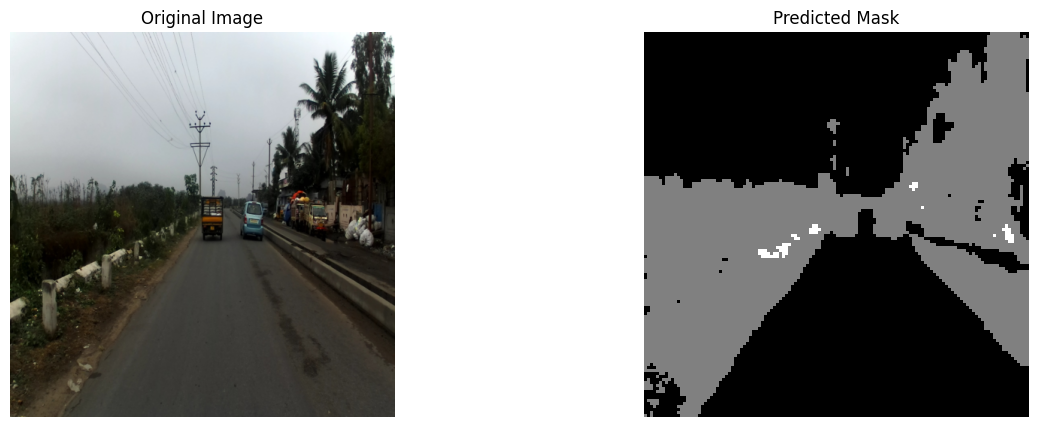

Processing and Saving Overlays:   0%|          | 0/2009 [00:00<?, ?it/s]C:\Users\Ahmad\AppData\Local\Temp\ipykernel_25296\717784667.py:101: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  predicted_mask_resized = Image.fromarray(predicted_mask.astype(np.uint8)).resize(original_image.size, resample=Image.NEAREST)
Processing and Saving Overlays: 100%|██████████| 2009/2009 [19:59<00:00,  1.68it/s]


In [11]:
class ImageOnlyDataset(Dataset):
    def __init__(self, image_root, feature_extractor, transforms=None):
        self.image_paths = []
        self.feature_extractor = feature_extractor
        self.transforms = transforms

        # Collect all image paths
        for subdir, _, files in tqdm(os.walk(image_root)):  # Iterate through image_root
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):  # Adjust for your image format
                    image_path = Path(subdir) / file
                    self.image_paths.append(image_path)

        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)

        # Prepare inputs for the model
        return {
            "pixel_values": image,  # Preprocessed image
            "image_path": str(self.image_paths[idx]),  # Keep the path for saving predictions
        }


# Paths for the test dataset
test_image_root = os.path.join(image_root, "test")

# Create the test dataset instance
test_dataset = ImageOnlyDataset(test_image_root, feature_extractor, transforms=transform)

# Visualize predictions for a sample from the test dataset
def infer_and_visualize(dataset, model, idx=0):
    sample = dataset[idx]
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)  # Add batch dimension and move to device
    image_path = sample["image_path"]  # Save the original image path

    # Run the model to get predictions
    with torch.no_grad():
        outputs = model(pixel_values)
    predicted_mask = torch.argmax(outputs.logits.squeeze(), dim=0).cpu().numpy()

    # Convert tensors back to images for visualization
    image = transforms.ToPILImage()(sample["pixel_values"])
    predicted_mask_img = Image.fromarray(predicted_mask.astype(np.uint8))

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask_img, cmap="gray")
    plt.axis("off")

    plt.show()

# Load the fine-tuned Segformer model
model = SegformerForSemanticSegmentation.from_pretrained("segformer-finetuned")

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Visualize a sample from the test dataset
infer_and_visualize(test_dataset, model, idx=0)
from matplotlib import colors as mcolors

# Define a color map for different classes
def get_colormap(num_classes):
    colormap = list(mcolors.CSS4_COLORS.values())[:num_classes]
    return colormap

# Overlay the predicted mask on the original image and save
def overlay_and_save(dataset, model, save_dir="overlayed_predictions", num_classes=34):
    os.makedirs(save_dir, exist_ok=True)
    colormap = get_colormap(num_classes)

    for i in tqdm(range(len(dataset)), desc="Processing and Saving Overlays"):
        sample = dataset[i]
        pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
        image_path = sample["image_path"]

        # Run inference
        with torch.no_grad():
            outputs = model(pixel_values)
        predicted_mask = torch.argmax(outputs.logits.squeeze(), dim=0).cpu().numpy()

        # Convert tensors back to images for overlay
        original_image = transforms.ToPILImage()(sample["pixel_values"])
        predicted_mask_resized = Image.fromarray(predicted_mask.astype(np.uint8)).resize(original_image.size, resample=Image.NEAREST)
        predicted_overlay = Image.new("RGBA", original_image.size)

        # Assign colors to the predicted mask
        for class_id in range(num_classes):
            class_mask = (np.array(predicted_mask_resized) == class_id).astype("uint8") * 255
            overlay = Image.new("RGBA", original_image.size, colormap[class_id])
            predicted_overlay = Image.composite(overlay, predicted_overlay, Image.fromarray(class_mask))

        # Blend the overlay with the original image
        overlayed_image = Image.blend(original_image.convert("RGBA"), predicted_overlay, alpha=0.5)

        # Save the resulting overlayed image
        base_name = os.path.basename(image_path).replace(".jpg", "_overlay.png").replace(".png", "_overlay.png")
        overlayed_image.save(os.path.join(save_dir, base_name))

# Run overlay and save
overlay_and_save(test_dataset, model)
